**Πρόβλεψη σφαλμάτων σε HVAC-Variable Air Volume με χρήση της βιβλιοθήκης PyTorch**



**Στόχος:** Η ανίχνευση πιθανών σφαλμάτων σε μια υπομονάδα VAV ενός συστήματος HVAC(Heating, Ventilation, Air-conditioning). Το σύνολο δεδομένων που χρησιμοποιήθηκε, παρήχθηκε μέσω προσομοίωσης στο εργαστήριο Pacific Northwest National Laboratory(PNNL). Το μοντέλο του κτιρίου και του συστήματος HVAC αναπτύχθηκαν συνδυαστικά στα προγράμματα EnergyPlus και Dymola. Πρόκειται για ένα πρόβλημα δυαδικής ταξινόμησης με επιτηρούμενη μάθηση με τη χρήση τεχνητών νευρώνων στο PyTorch

Τα σύνολα δεδομένων(datasets) καθώς και η περιγραφή τους βρίσκονται στη διεύθυνση: https://figshare.com/articles/dataset/LBNLDataSynthesisInventory_pdf/11752740





Αρχικά, εισάγουμε τις απαραίτητες βιβλιοθήκες που θα χρειαστούμε

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn                                                               
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Κάνουμε import από το Drive το dataset MZVAV-2-2, και το αναθέτουμε σε ένα αντικείμενο τύπου DataFrame. Ας δούμε τη μορφή που έχουν τα δεδομένα παίρνοντας τα πρώτα 5 records

In [ ]:
data_filename = "/content/drive/MyDrive/granderson_datasets/MZVAV-2-2.csv"
data = pd.read_csv(data_filename)
data.head()

,Datetime,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
0,8/28/2007 0:00,77.13,55,80.61,75.86,75.19,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.06,0,1
1,8/28/2007 0:01,77.63,55,80.68,75.38,75.18,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.17,0,1
2,8/28/2007 0:02,77.87,55,80.66,75.28,75.18,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.34,0,1
3,8/28/2007 0:03,77.95,55,80.69,75.27,75.20,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,0.57,0,1
4,8/28/2007 0:04,78.59,55,80.60,75.29,75.24,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.4,1.00,0,1


Οι διαστάσεις του πίνακα είναι

In [ ]:
data.shape

(37440, 19)

Ελέγχουμε αν υπάρχουν διπλές εμφανίσεις κάποιας γραμμής ώστε να την αφαιρέσουμε, αλλά βλέπουμε ότι δεν υπάρχουν

In [ ]:
data.duplicated().sum()

0

Ελέχουμε τα δεδομένα για κενές τιμές σε κάποιο feature

In [ ]:
data.isna().sum()

Datetime                                          0
AHU: Supply Air Temperature                       0
AHU: Supply Air Temperature Set Point             0
AHU: Outdoor Air Temperature                      0
AHU: Mixed Air Temperature                        0
AHU: Return Air Temperature                       0
AHU: Supply Air Fan Status                        0
AHU: Return Air Fan Status                        0
AHU: Supply Air Fan Speed Control Signal          0
AHU: Return Air Fan Speed Control Signal          0
AHU: Exhaust Air Damper Control Signal            0
AHU: Outdoor Air Damper Control Signal            0
AHU: Return Air Damper Control Signal             0
AHU: Cooling Coil Valve Control Signal            0
AHU: Heating Coil Valve Control Signal            0
AHU: Supply Air Duct Static Pressure Set Point    0
AHU: Supply Air Duct Static Pressure              0
Occupancy Mode Indicator                          0
Fault Detection Ground Truth                      0
dtype: int64

Δεν υπάρχουν κενές τιμές στα δεδομένα

Με τη μέθοδο describe() μπορούμε να δούμε διάφορα στοιχεία περιγραφικής στατιστικής για κάθε χαρακτηριστικό(feature)


In [ ]:
data.describe()

,AHU: Supply Air Temperature,AHU: Supply Air Temperature Set Point,AHU: Outdoor Air Temperature,AHU: Mixed Air Temperature,AHU: Return Air Temperature,AHU: Supply Air Fan Status,AHU: Return Air Fan Status,AHU: Supply Air Fan Speed Control Signal,AHU: Return Air Fan Speed Control Signal,AHU: Exhaust Air Damper Control Signal,AHU: Outdoor Air Damper Control Signal,AHU: Return Air Damper Control Signal,AHU: Cooling Coil Valve Control Signal,AHU: Heating Coil Valve Control Signal,AHU: Supply Air Duct Static Pressure Set Point,AHU: Supply Air Duct Static Pressure,Occupancy Mode Indicator,Fault Detection Ground Truth
count,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.000000,37440.0,37440.000000,37440.000000,37440.000000
mean,63.237180,55.662126,64.445303,66.916624,68.218243,0.653846,0.500000,0.568830,0.362148,0.286949,0.286949,0.713051,0.203983,0.050786,1.4,1.343421,0.500000,0.500000
std,11.940915,2.486567,18.987496,14.653489,7.483220,0.475749,0.500007,0.430636,0.387902,0.340170,0.340170,0.340170,0.286489,0.206367,0.0,1.409967,0.500007,0.500007
min,23.850000,55.000000,1.540000,1.540000,50.390000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.4,-0.490000,0.000000,0.000000
25%,54.980000,55.000000,60.677500,63.360000,60.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,1.4,0.010000,0.000000,0.000000
50%,60.805000,55.000000,68.470000,71.300000,71.180000,1.000000,0.500000,0.710000,0.240000,0.400000,0.400000,0.600000,0.000000,0.000000,1.4,1.350000,0.500000,0.500000
75%,71.850000,55.000000,75.582500,74.270000,72.110000,1.000000,1.000000,1.000000,0.580000,0.400000,0.400000,1.000000,0.470000,0.000000,1.4,1.780000,1.000000,1.000000
max,107.940000,65.000000,91.850000,90.300000,90.870000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.4,5.010000,1.000000,1.000000


...Καθώς επίσης και να δούμε τί τύπο έχουν τα δεδομένα κάθε στήλης με τη μέθοδο info(), ώστε να ξέρουμε πως θα τα διαχειριστούμε

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37440 entries, 0 to 37439
Data columns (total 19 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Datetime                                        37440 non-null  object 
 1   AHU: Supply Air Temperature                     37440 non-null  float64
 2   AHU: Supply Air Temperature Set Point           37440 non-null  int64  
 3   AHU: Outdoor Air Temperature                    37440 non-null  float64
 4   AHU: Mixed Air Temperature                      37440 non-null  float64
 5   AHU: Return Air Temperature                     37440 non-null  float64
 6   AHU: Supply Air Fan Status                      37440 non-null  int64  
 7   AHU: Return Air Fan Status                      37440 non-null  int64  
 8   AHU: Supply Air Fan Speed Control Signal        37440 non-null  float64
 9   AHU: Return Air Fan Speed Control Signa

# Προεπεξεργασία δεδομένων

Θα αφαιρέσουμε τη στήλη Datetime, που είναι τύπου object

In [ ]:
df = data
df = data.drop(columns = 'Datetime')
df = df.drop(columns = 'AHU: Supply Air Duct Static Pressure Set Point')
df.shape

(37440, 17)

Η εξαρτημένη μεταβλητή βρίσκεται στην τελευταία στήλη. Ελέχουμε την κατανομή περιπτώσεων χωρίς σφάλμα και με σφάλμα

In [ ]:
df['Fault Detection Ground Truth'].value_counts()

1    18720
0    18720
Name: Fault Detection Ground Truth, dtype: int64

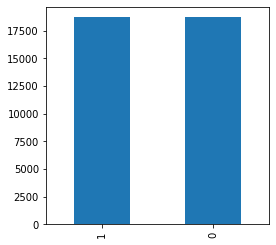

In [ ]:
plt.figure(figsize=(4,4))
df['Fault Detection Ground Truth'].value_counts().plot(kind='bar')
plt.show()

Παρατηρούμε ότι τα δεδομένα είναι balanced και μπορούν να χρησιμοποιηθούν απευθείας για εκπαίδευση, αφού κλιμακωθούν κατάλληλα

Διαχωρίζουμε τα δεδομένα σε δεδομένα εκπαίδευσης και δεδομένα ελέγχου, τόσο για τις ανεξάρτητες όσο και για την εξαρτημένη μεταβλητή

In [ ]:
X =df.drop(columns='Fault Detection Ground Truth')
y = df['Fault Detection Ground Truth'].values
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=.3, random_state = 1, stratify = y)

Ας δούμε τις διαστασιμότητες των συνόλων εκπαίδευσης και ελέγχου, για να μπορούμε να φτιάξουμε το μοντέλο μας

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26208, 16), (11232, 16), (26208,), (11232,))

Επειδή το μοντέλο θα χρησιμοποιεί στοχαστική κάθοδο κλίσης(SGD), είναι καλό να κανονικοποιήσουμε τα δεδομένα, έτσι ώστε να έχουν μέση τιμή 0 και διακύμανση 1. Αυτό το κάνει ο StandardScaler

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Εξάγουμε τα training & testing datasets για μελλοντικη χρήση σε άλλα μοντελα

In [ ]:
pd.DataFrame(X_train).to_csv('/content/drive/MyDrive/tempdata/X.csv') 
pd.DataFrame(y_train).to_csv('/content/drive/MyDrive/tempdata/Y.csv') 
pd.DataFrame(X_test).to_csv('/content/drive/MyDrive/tempdata/x.csv') 
pd.DataFrame(y_test).to_csv('/content/drive/MyDrive/tempdata/y.csv') 

# Δημιουργία μοντέλου

Μετατρέπουμε τα δεδομένα σε τανυστές(tensors), για να χρησιμοποιηθούν ως είσοδοι στο νευρωνικό δίκτυο

In [ ]:
X_train = torch.tensor(X_train, requires_grad = True, dtype=torch.float32)
y_train = torch.LongTensor(y_train)
X_test = torch.tensor(X_test, requires_grad = True, dtype=torch.float32)
y_test = torch.LongTensor(y_test)

Ρυθμίζουμε τις υπερπαραμέτρους του δικτύου

In [ ]:
epoch = 2000
learning_rate = 0.1
n_features = X_train.shape[1]

In [ ]:
class Classifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
             )
        
     
    def forward(self, x): 
        return self.layers(x)
        

In [ ]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
errors = []

Τρέχουμε επαναληπτικά τα βήματα που περιγράφουν το μοντέλο (Σημείωση: στο tensorflow η διαδικασία αυτή γίνεται αυτόματα με τη μέθοδο fit()

In [ ]:
for i in range(epoch): 
    output = model(X_train)
    loss = criterion(output, y_train)
    errors.append(loss.item())
    #Setting the gradients to zero
    optimizer.zero_grad()
    #running the back propagation 
    loss.backward()
    #Updating the weights 
    optimizer.step()
    print(f'Epoch : {i+1}, loss => {loss}')

Epoch : 1, loss => 0.702278733253479
Epoch : 2, loss => 0.7007105946540833
Epoch : 3, loss => 0.6993473172187805
Epoch : 4, loss => 0.6981610059738159
Epoch : 5, loss => 0.6971113085746765
Epoch : 6, loss => 0.6961573958396912
Epoch : 7, loss => 0.6953192949295044
Epoch : 8, loss => 0.694572925567627
Epoch : 9, loss => 0.6939019560813904
Epoch : 10, loss => 0.6932918429374695
Epoch : 11, loss => 0.6927343606948853
Epoch : 12, loss => 0.6922217607498169
Epoch : 13, loss => 0.6917480230331421
Epoch : 14, loss => 0.6913080811500549
Epoch : 15, loss => 0.6909002065658569
Epoch : 16, loss => 0.6905205845832825
Epoch : 17, loss => 0.6901634931564331
Epoch : 18, loss => 0.6898240447044373
Epoch : 19, loss => 0.6894991993904114
Epoch : 20, loss => 0.6891851425170898
Epoch : 21, loss => 0.6888808608055115
Epoch : 22, loss => 0.6885873675346375
Epoch : 23, loss => 0.688299298286438
Epoch : 24, loss => 0.6880100965499878
Epoch : 25, loss => 0.6877225041389465
Epoch : 26, loss => 0.687435150146484

Μόλις ολοκληρωθεί η εκπαίδευση, ελέγχουμε τα αποτελέσματα και την ακρίβεια του μοντέλου

In [ ]:
results = None
with torch.no_grad():
    output = model(X_test)
    _, pred = torch.max(output, dim=1)
    results = pred

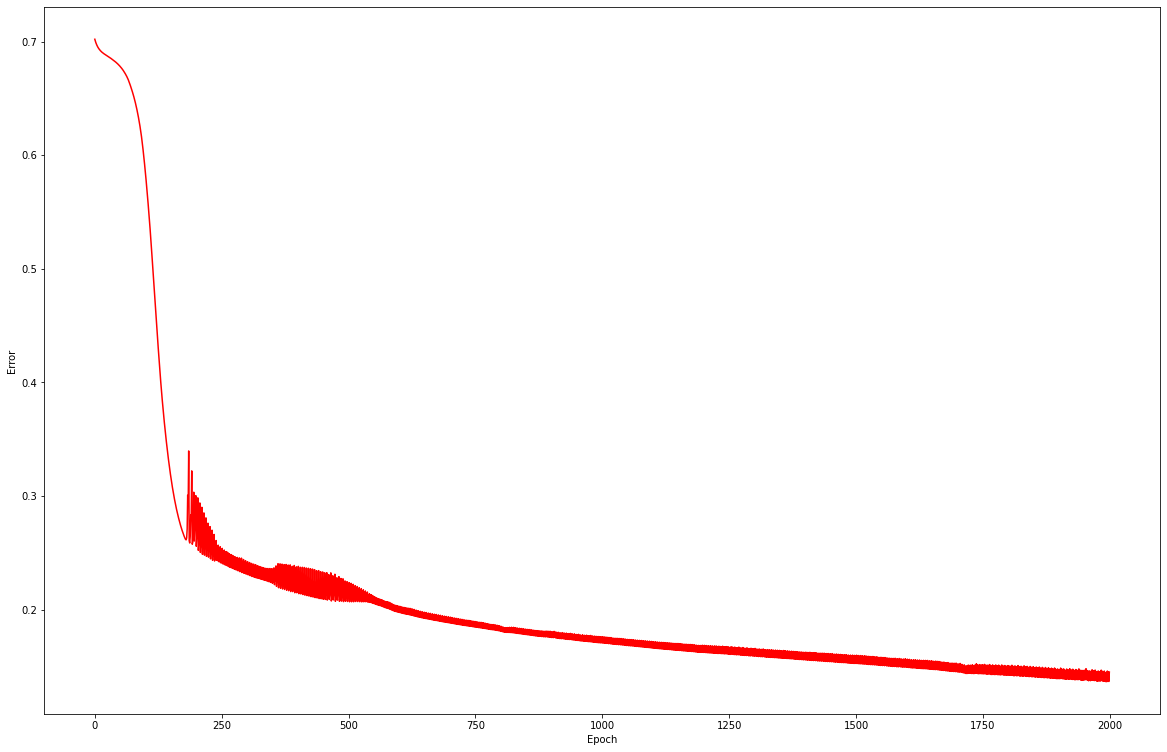

In [ ]:
lnt = [i for i in range(len(errors))]
plt.figure(figsize=(20,13))
plt.plot(lnt, errors, color='red')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()

Η απώλεια(loss) είναι το άθροισμα των σφαλμάτων σε κάθε εποχή. Βλέπουμε ότι η απώλεια για το σετ εκπαίδευσης μειώνεται με το χρόνο, που σημαίνει ότι γίνεται καλή προσαρμογή(fit) στα δεδομένα

In [ ]:
#Checking the accuracies.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
rst = [i.item() for i in results]
acc = accuracy_score(y_test, rst)

acc

0.9306445868945868

Από τα παραπάνω βλέπουμε ότι η **ακρίβεια** του μοντέλου είναι **93.7%**

In [ ]:
cm = confusion_matrix(y_test, results)
cm

array([[5223,  393],
       [ 386, 5230]])

Σχεδιάζουμε τον πίνακα σύγχυσης με τα αποτελέσματα του testing

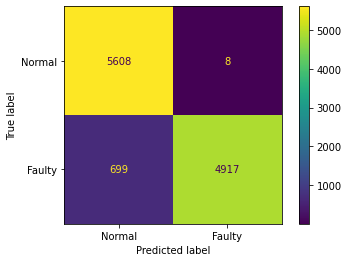

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, results)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Faulty"])
disp.plot()

plt.show()

*Το* μοντέλο φαίνεται να τα πηγαίνει πολυ καλά σε μελλοντικά δεδομένα. Παρατηρούμε ότι τα false positives ειναι μόλις 8 που σημαίνει ότι έχουμε πετύχει το να μην υπάρχει false alarm για κάποιο σφάλμα. Από την άλλη ίσως κάποια σφάλματα να περάσουν απαρατήρητα στο μέλλον.

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test, results)

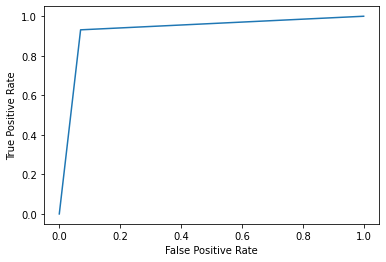

In [ ]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()